<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(H2O_Molecular_Optimized)_mkbahk_20251215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0
!pip install py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 17.6 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d247130465b101e3f036cff62bdbdda2cf724078a118433a8819629d0448575c
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import datetime
import time

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP

from qiskit.primitives import Estimator

In [5]:
# 1. PySCFDriver 설정 (STO-3G basis, 실험적 geometry)
driver = PySCFDriver(
    atom="H 0.0 0.0 0.0; H 0.0 0.0 0.74",
    #atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0",
    basis="sto3g",
    charge=0,
    spin=0
)
problem = driver.run()  # ElectronicStructureProblem 생성

In [6]:
# 2. Mapper 설정 (ParityMapper + 2-qubit reduction)
mapper = ParityMapper(num_particles=problem.num_particles)

In [7]:
# 3. Ansatz 설정 (UCCSD + HartreeFock initial state)
initial_state = HartreeFock(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper
)
ansatz = UCCSD(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper,
    initial_state=initial_state
)

In [8]:
#ansatz.decompose().draw("mpl")
ansatz.decompose().draw()

┌───┐┌────────────────────┐┌────────────────────┐»
q_0: ┤ X ├┤0                   ├┤0                   ├»
     └───┘│  exp(-it IY)(t[0]) ││  exp(-it YI)(t[1]) │»
q_1: ─────┤1                   ├┤1                   ├»
          └────────────────────┘└────────────────────┘»
«     ┌───────────────────────────┐
«q_0: ┤0                          ├
«     │  exp(-it (XY + YX))(t[2]) │
«q_1: ┤1                          ├
«     └───────────────────────────┘

In [9]:
# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def


루틴 시작 시간: 23시 46분 45초


In [10]:
# 4. Optimizer와 VQE 설정
optimizer = SLSQP(maxiter=1000)  # 충분한 iteration으로 수렴 보장
estimator = Estimator()  # Noiseless simulator primitive
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)


In [11]:
# 5. GroundStateEigensolver로 실행
solver = GroundStateEigensolver(qubit_mapper=mapper, solver=vqe)

result = solver.solve(problem)

print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


1  단계:  -0.8209947583637789 		총 실행 시간: 00시 00분 00초
2  단계:  -0.8209947499366403 		총 실행 시간: 00시 00분 00초
3  단계:  -0.820994745721948 		총 실행 시간: 00시 00분 00초
4  단계:  -0.8209947478557161 		총 실행 시간: 00시 00분 00초
5  단계:  -1.4573117834152403 		총 실행 시간: 00시 00분 00초
6  단계:  -1.4573117766686114 		총 실행 시간: 00시 00분 00초
7  단계:  -1.4573117901071742 		총 실행 시간: 00시 00분 00초
8  단계:  -1.4573118008520076 		총 실행 시간: 00시 00분 00초
9  단계:  -1.770622678743075 		총 실행 시간: 00시 00분 00초
10  단계:  -1.7706226839187738 		총 실행 시간: 00시 00분 00초
11  단계:  -1.7706226846345345 		총 실행 시간: 00시 00분 00초
12  단계:  -1.7706226730561847 		총 실행 시간: 00시 00분 00초
13  단계:  -1.7878574552052504 		총 실행 시간: 00시 00분 00초
14  단계:  -1.8478814168028461 		총 실행 시간: 00시 00분 00초
15  단계:  -1.8478814164652078 		총 실행 시간: 00시 00분 00초
16  단계:  -1.8478814162747728 		총 실행 시간: 00시 00분 00초
17  단계:  -1.8478814143810514 		총 실행 시간: 00시 00분 00초
18  단계:  -1.8493170479365901 		총 실행 시간: 00시 00분 00초
19  단계:  -1.852049680946133 		총 실행 시간: 00시 00분 00초
20  단계:  -1.852049681297

In [13]:
# 결과 출력
print("Total ground state energy (Hartree):", result.total_energies[0])
print("Nuclear repulsion energy:", result.nuclear_repulsion_energy)
print("Electronic ground state energy:", result.electronic_energies[0])
print("\nFull result:")
print(result)

Total ground state energy (Hartree): -1.137283800792749
Nuclear repulsion energy: 0.7151043390810812
Electronic ground state energy: -1.8523881398738302

Full result:
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.852388139874
  - computed part:      -1.852388139874
~ Nuclear repulsion energy (Hartree): 0.715104339081
> Total ground state energy (Hartree): -1.137283800793
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39839733]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.397982500886]
    - computed part:      [0.0  0.0  1.397982500886]
  > Dipole moment (a.u.): [0.0  0.0  0.000414829114]  Total: 0.000414829114
                 (debye): [0.0  0.0  0.001054390338]  Total: 0.001054390338
 


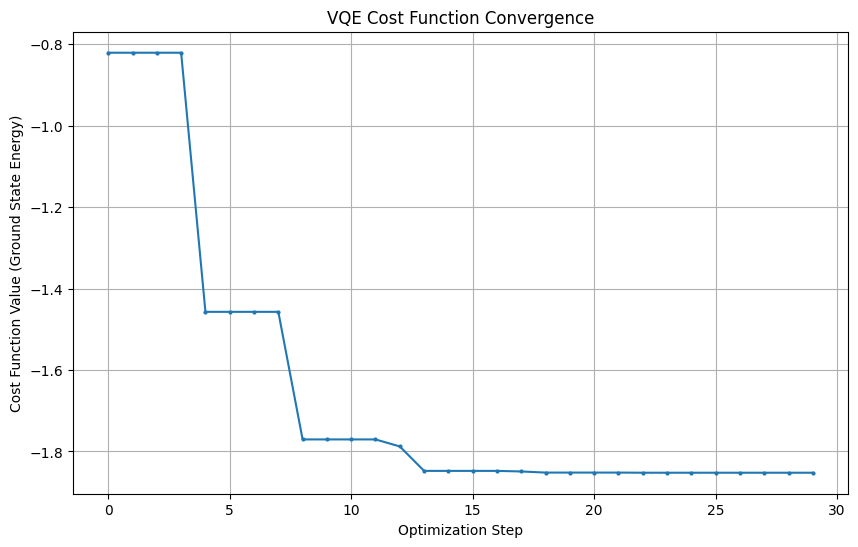

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()